# Experimental notebook for different data loaders

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
os.chdir('..')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision.transforms as transforms
import torch

from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# EXPERIMENT_NAME = "unet_isic2018"

# ROOT_DIR = os.path.abspath(".")
# LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

# if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
#     os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
# if not os.path.exists(LOG_PATH):
#     os.mkdir(LOG_PATH)

cuda:0


In [5]:
class ISIC2018_dataloader(Dataset):
    """
    ISIC 2018 data loader with Irregular Masks Dataset.
    """
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        self._input_folder = os.path.join(self._data_folder, 'ISIC2018_Task1-2_Training_Input')
        self._label_folder = os.path.join(self._data_folder, 'ISIC2018_Task1_Training_GroundTruth')
        self._scribbles_folder = os.path.join(self._data_folder, 'SCRIBBLES')
        self._images = sorted(glob.glob(self._input_folder + "/*.jpg"))
        self._labels = sorted(glob.glob(self._label_folder + "/*.png"))
        self._scribbles = sorted(glob.glob(self._scribbles_folder + "/*.png")) # For heavy masking [::-1]
        
        self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self._images, 
                                                                                                    self._labels,
                                                                                                    test_size=0.2, shuffle=False, random_state=0)

        
    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
            scribble_path = self._scribbles[np.random.randint(1000)] # pick randomly from first 1000 scribbles
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            scribble_path = self._scribbles[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = cv2.imread(mask_path, 0)
        
        mask[mask<=127] = 0
        mask[mask>127] = 1
        mask = cv2.resize(mask, (224, 224), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=0)
        scribble = Image.open(scribble_path).convert('P')
        
        
        transforms_image = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = torch.from_numpy(mask)
        scribble = transforms_mask(scribble)
        
        ###############################
        #partial_image1 = image * mask * cmask
        #partial_image2 = image * cmask * (1 - mask)
        ###############################
        
        # Masked image
        partial_image1 = image * (torch.max(scribble) - scribble) 
        partial_image2 = image * scribble
        
        sample = {'image': image, 
                  'mask': mask, 
                  'partial_image1': partial_image1,
                  'partial_image2': partial_image2}
        return sample


class GLAS_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        if self.is_train:
            self._input_folder = os.path.join(self._data_folder, "train", 'img')
            self._label_folder = os.path.join(self._data_folder, "train", 'labelcol')
            self.train_images = sorted(glob.glob(self._input_folder + "/*.png"))
            self.train_labels = sorted(glob.glob(self._label_folder + "/*.png"))
        else:
            self._input_folder = os.path.join(self._data_folder, "test", 'img')
            self._label_folder = os.path.join(self._data_folder, "test", 'labelcol')
            self.test_images = sorted(glob.glob(self._input_folder + "/*.png"))
            self.test_labels = sorted(glob.glob(self._label_folder + "/*.png"))
        
        self._scribbles_folder = os.path.join(self._data_folder, 'SCRIBBLES')
        self._scribbles = sorted(glob.glob(self._scribbles_folder + "/*.png"))[:1000] # For heavy masking [::-1]

    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
            scribble_path = self._scribbles[random.randint(0,999)] # pick randomly from first 1000 scribbles
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            scribble_path = self._scribbles[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = cv2.imread(mask_path, 0)
        mask[mask<=127] = 0
        mask[mask>127] = 1
        mask = cv2.resize(mask, (224, 224), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=0)
        scribble = Image.open(scribble_path).convert('P')
        
        
        transforms_image = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = torch.from_numpy(mask)
        scribble = transforms_mask(scribble)
        
        ###############################
        #partial_image1 = image * mask * cmask
        #partial_image2 = image * cmask * (1 - mask)
        ###############################
        
        # Masked image
        partial_image1 = image * (torch.max(scribble) - scribble) 
        partial_image2 = image * scribble
        
        sample = {'image': image, 
                  'mask': mask, 
                  'partial_image1': partial_image1,
                  'partial_image2': partial_image2}
        return sample


class RITE_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        if self.is_train:
            self._input_folder = os.path.join(self._data_folder, "train", 'img')
            self._label_folder = os.path.join(self._data_folder, "train", 'labelcol')
            self.train_images = sorted(glob.glob(self._input_folder + "/*.png"))
            self.train_labels = sorted(glob.glob(self._label_folder + "/*.png"))
        else:
            self._input_folder = os.path.join(self._data_folder, "test", 'img')
            self._label_folder = os.path.join(self._data_folder, "test", 'labelcol')
            self.test_images = sorted(glob.glob(self._input_folder + "/*.png"))
            self.test_labels = sorted(glob.glob(self._label_folder + "/*.png"))
        
        self._scribbles_folder = os.path.join(self._data_folder, 'SCRIBBLES')
        self._scribbles = sorted(glob.glob(self._scribbles_folder + "/*.png"))[:1000] # For heavy masking [::-1]

    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
            scribble_path = self._scribbles[random.randint(0,950)] # pick randomly from first 1000 scribbles
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            scribble_path = self._scribbles[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = cv2.imread(mask_path, 0)
        mask[mask<=127] = 0
        mask[mask>127] = 1
        mask = cv2.resize(mask, (224, 224), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=0)
        scribble = Image.open(scribble_path).convert('P')
        
        
        transforms_image = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = torch.from_numpy(mask)
        scribble = transforms_mask(scribble)
        
        ###############################
        #partial_image1 = image * mask * cmask
        #partial_image2 = image * cmask * (1 - mask)
        ###############################
        
        # Masked image
        partial_image1 = image * (torch.max(scribble) - scribble) 
        partial_image2 = image * scribble
        
        sample = {'image': image, 
                  'mask': mask, 
                  'partial_image1': partial_image1,
                  'partial_image2': partial_image2}
        return sample

    
class CVCLINICDB_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        self._input_folder = os.path.join(self._data_folder, 'Original')
        self._label_folder = os.path.join(self._data_folder, 'GroundTruth')
        self._scribbles_folder = os.path.join(self._data_folder, 'SCRIBBLES')
        self._images = sorted(glob.glob(self._input_folder + "/*.png"))
        self._labels = sorted(glob.glob(self._label_folder + "/*.png"))
        self._scribbles = sorted(glob.glob(self._scribbles_folder + "/*.png"))
        
        #import ipdb; ipdb.set_trace()
        
        self.train_images, self.test_images, self.train_labels, self.test_labels, self.train_scribbles, self.test_scribbles = train_test_split(self._images, 
                                                                                                    self._labels,
                                                                                                    self._scribbles[:len(self._images)],
                                                                                                    test_size=0.1, shuffle=False, random_state=0)

        
    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
            scribble_path = self._scribbles[np.random.randint(1000)] # pick randomly from first 1000 scribbles
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            scribble_path = self._scribbles[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = cv2.imread(mask_path, 0)
        
        mask[mask<=127] = 0
        mask[mask>127] = 1
        mask = cv2.resize(mask, (224, 224), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=0)
        scribble = Image.open(scribble_path).convert('P')
        
        
        transforms_image = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop((224,224)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = torch.from_numpy(mask)
        scribble = transforms_mask(scribble)
        
        ###############################
        #partial_image1 = image * mask * cmask
        #partial_image2 = image * cmask * (1 - mask)
        ###############################
        
        # Masked image
        partial_image1 = image * (torch.max(scribble) - scribble) 
        partial_image2 = image * scribble
        
        sample = {'image': image, 
                  'mask': mask, 
                  'partial_image1': partial_image1,
                  'partial_image2': partial_image2}
        return sample

# train_dataset = ISIC2018_dataloader("datasets/ISIC2018")
# test_dataset = ISIC2018_dataloader("datasets/ISIC2018", is_train=False)

# train_dataset = GLAS_dataloader("datasets/GLAS")
# test_dataset = GLAS_dataloader("datasets/GLAS", is_train=False)

# train_dataset = RITE_dataloader("datasets/RITE")
# test_dataset = RITE_dataloader("datasets/RITE", is_train=False)

train_dataset = CVCLINICDB_dataloader("datasets/CVCLINICDB")
test_dataset = CVCLINICDB_dataloader("datasets/CVCLINICDB", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

In [6]:
dt = next(iter(train_dataloader))
x = dt["image"]
y = dt["mask"]
z = dt["partial_image1"]
x.shape, y.shape, z.shape

(torch.Size([8, 3, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 3, 224, 224]))

In [7]:
torch.unique(y) # tensor([0., 1.])

tensor([0, 1], dtype=torch.uint8)

In [8]:
y.dtype

torch.uint8

(224, 224, 3)


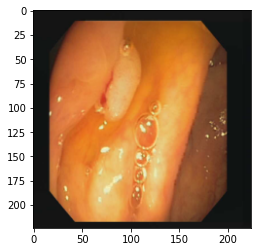

In [9]:
def to_img(ten):
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

a = to_img(x)
print(a.shape)
plt.imshow(a)
#plt.imshow(a, cmap='gray')

In [10]:
# array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
#         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
#         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
#         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
#         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  64,  65,
#         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
#         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
#         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
#        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
#        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
#        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
#        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
#        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
#        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
#        183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
#        196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
#        209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
#        222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
#        235, 236, 237, 238, 239], dtype=uint8)

np.unique(a)

array([  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19

(224, 224, 1)


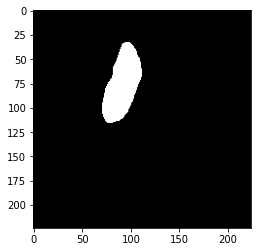

In [11]:
a = to_img(y)
print(a.shape)
plt.imshow(a, cmap='gray')

In [12]:
a.shape

(224, 224, 1)

In [13]:
np.unique(a) # array([127, 255], dtype=uint8)

array([127, 255], dtype=uint8)

(224, 224, 3)


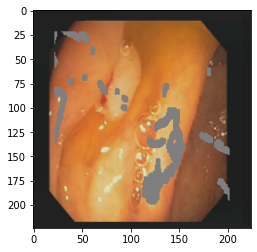

In [14]:
a = to_img(z)
print(a.shape)
plt.imshow(a, cmap='gray')

In [15]:
np.random.randint(1000)

684

In [ ]:
np.unique(a)